<a href="https://colab.research.google.com/github/i-ganza007/Call_of_the_wild/blob/main/Summative_Intro_to_ml_%5BIan_Ganza%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [1]:
import librosa
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import pandas as pd
import os
import numpy as np
import random
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from PIL import Image

# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


In [ ]:
"""
The aim of this project is to build a model that is able to classify birds by it's sounds
We will be using the Wester Mediterranean Wetland Birds Dataset (https://zenodo.org/record/7505820#.Y-zEQXbMJD9)
that has been manually labeled with species of the Aiguamolls del Empordà natural park in Girona, Spain.
The dataset contains 20 classes of different species represented in 5,795  audio files
"""

In [2]:
# Getting data
!wget -O spectograms.zip "https://zenodo.org/records/7505820/files/spectrograms.zip?download=1"
!wget -O audio.zip 'https://zenodo.org/records/7505820/files/audio_files.zip?download=1'
!unzip -q spectograms.zip -d spectrograms
!unzip -q audio.zip -d audio

--2025-06-20 07:42:53--  https://zenodo.org/records/7505820/files/spectrograms.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2981250025 (2.8G) [application/octet-stream]
Saving to: ‘spectograms.zip’

spectograms.zip     100%[===================>]   2.78G  6.77MB/s    in 9m 34s  

2025-06-20 07:52:27 (4.96 MB/s) - ‘spectograms.zip’ saved [2981250025/2981250025]

--2025-06-20 07:52:27--  https://zenodo.org/records/7505820/files/audio_files.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1041126810 (993M) [application/octet-stream]
Saving to: ‘audio.zip’

audio.zip           100%[===================>] 992.90M  4.20MB/s    in 4m 59s  

#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
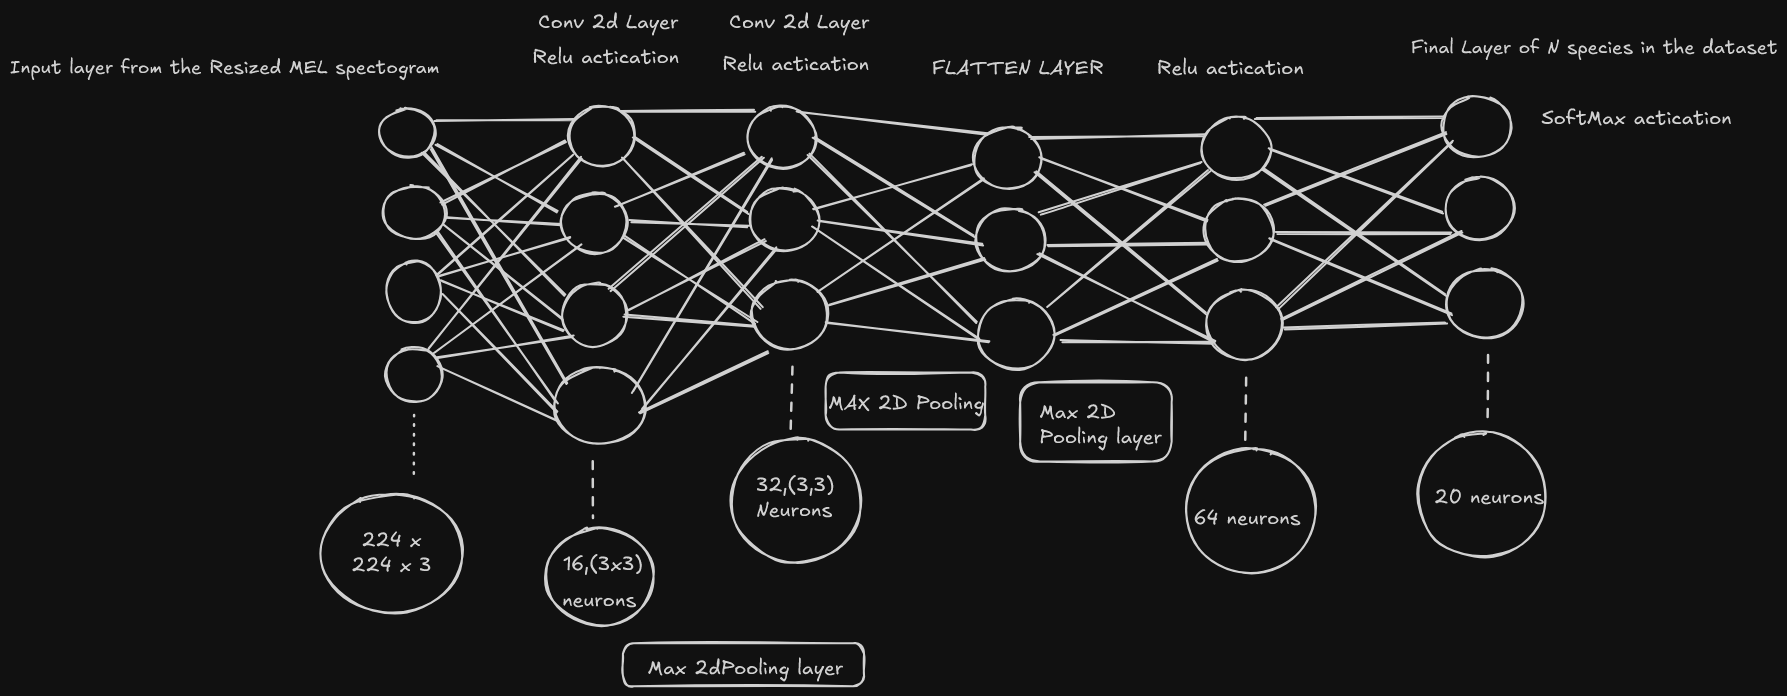
<!-- > <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/> -->




In [4]:
SPECTOGRAMS_PATH = "/content/spectrograms"
AUDIO_PATH = "/content/audio"
METADATA_PATH = "/content/metadata.csv"
metadata_df = pd.read_csv(METADATA_PATH,sep=";")
metadata_df.head()

,species,audio_name,spectrogram_name,sec_i,sec_f
0,Acrocephalus arundinaceus,XC417157.mp3,XC417157_0.npy,2.168,3.168
1,Acrocephalus arundinaceus,XC417157.mp3,XC417157_1.npy,2.968,3.968
2,Acrocephalus arundinaceus,XC417157.mp3,XC417157_2.npy,3.768,4.768
3,Acrocephalus arundinaceus,XC417157.mp3,XC417157_3.npy,4.568,5.108
4,Acrocephalus arundinaceus,XC417157.mp3,XC417157_4.npy,19.289,20.289


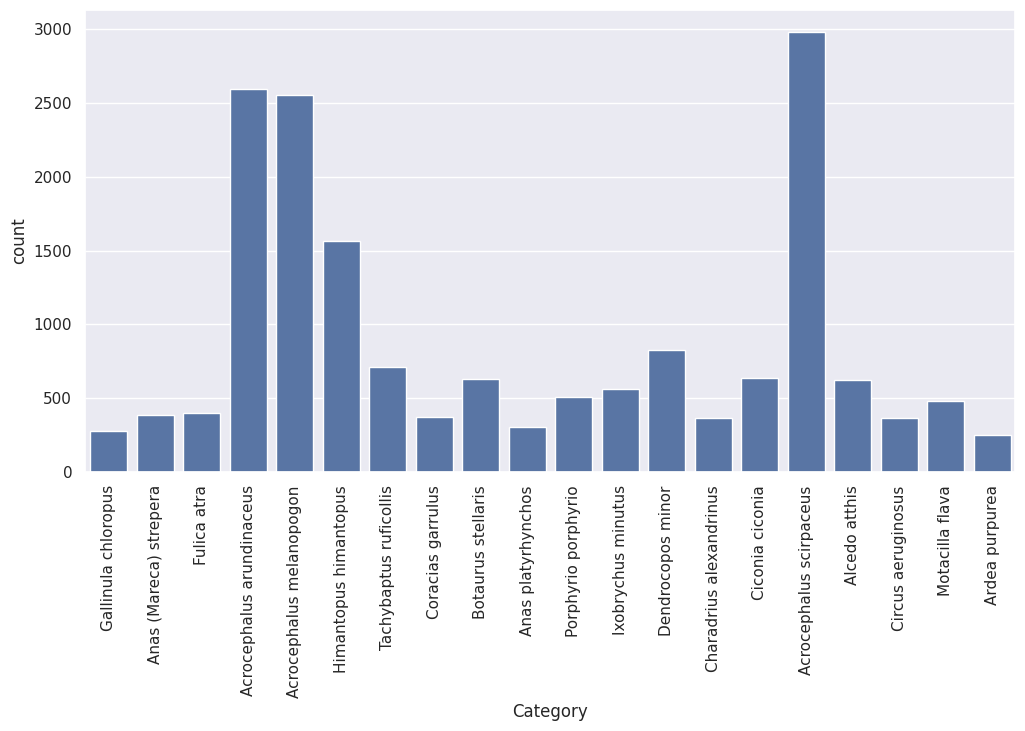

In [5]:
sns.set(rc={'figure.figsize':(12,6)})
data = []
for root, dirs, files in os.walk('spectrograms'):
    for file in files:
        category = os.path.basename(root)
        data.append({'filename': os.path.join(root, file), 'Category': category})

spectograms_df = pd.DataFrame(data)
sns.countplot(data=spectograms_df, x="Category")
plt.xticks(rotation=90)
plt.show()

In [6]:
spectograms_df['Category'].value_counts()

,count
Category,
Acrocephalus scirpaceus,2983
Acrocephalus arundinaceus,2599
Acrocephalus melanopogon,2555
Himantopus himantopus,1566
Dendrocopos minor,826
Tachybaptus ruficollis,710
Ciconia ciconia,636
Botaurus stellaris,629
Alcedo atthis,624


In [7]:
# Mapping the data to npy files from specto
def load_metadata_folders(PATH):

    df = []
    categories = os.listdir(PATH)
    for category in categories:
        for entry in os.listdir(PATH + '/' + category):
            df.append([entry,category])
    return df

spectograms_df = pd.DataFrame(load_metadata_folders(SPECTOGRAMS_PATH),columns=["File","Category"])
audio_df = pd.DataFrame(load_metadata_folders(AUDIO_PATH),columns=["File","Category"])
spectograms_df.head()

,File,Category
0,XC486755_7.npy,Gallinula chloropus
1,XC440482_16.npy,Gallinula chloropus
2,XC487693_7.npy,Gallinula chloropus
3,XC487692_19.npy,Gallinula chloropus
4,XC440482_5.npy,Gallinula chloropus


In [8]:
def train_val_test_split(df, categories, split_names, split_ratios):

    df['Split'] = None

    for category in categories:
        category_df = df[df['Category'] == category]
        total_count = len(category_df)
        current_index = 0
        for name, ratio in zip(split_names, split_ratios):
            split_count = int(total_count * (ratio / 100))
            df.loc[category_df.index[current_index:current_index + split_count], 'Split'] = name
            current_index += split_count

        if current_index < total_count:
            df.loc[category_df.index[current_index:total_count], 'Split'] = split_names[-1]

train_val_test_split(spectograms_df, spectograms_df['Category'].unique(), ['TRAIN', 'VAL', 'TEST'], [70, 20, 10])
spectograms_df.head()

,File,Category,Split
0,XC486755_7.npy,Gallinula chloropus,TRAIN
1,XC440482_16.npy,Gallinula chloropus,TRAIN
2,XC487693_7.npy,Gallinula chloropus,TRAIN
3,XC487692_19.npy,Gallinula chloropus,TRAIN
4,XC440482_5.npy,Gallinula chloropus,TRAIN


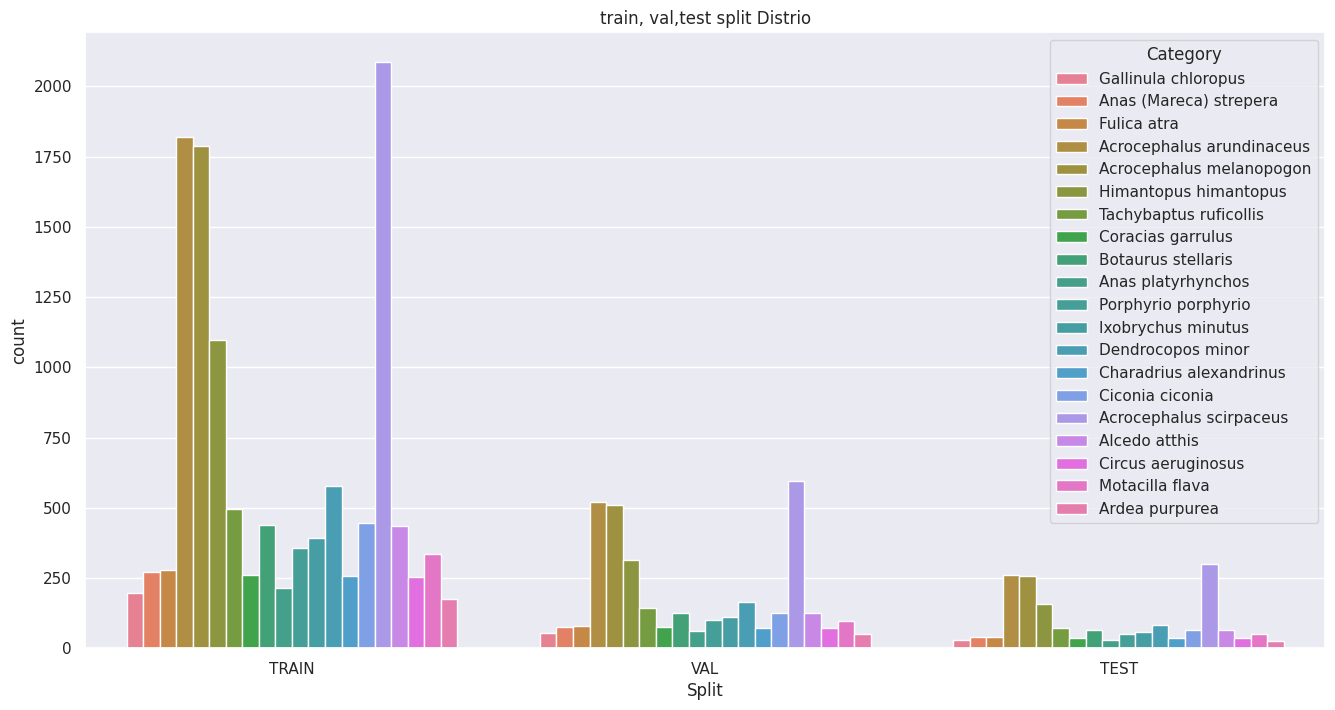

In [9]:
# Visualisation of the splits
plt.figure(figsize=(16,8))
sns.countplot(data=spectograms_df,x="Split",hue="Category").set(title="train, val,test split Distrio");

In [10]:
# Further spectogram labelling with audio extraction
def get_split_labels(n,labels,cuts):

    cuts = np.array(cuts)/100
    assigned_labels=[]
    for i in range(n):
        randint = np.random.rand()
        if (randint <= cuts[0]):
            assigned_labels.append(labels[0])
        if ((randint > cuts[0]) & (randint <= (cuts[0] + cuts[1]))):
            assigned_labels.append(labels[1])
        if ((randint > cuts[0] + cuts[1]) & (randint <= (cuts[0] + cuts[1] + cuts[2]))):
            assigned_labels.append(labels[2])
    return assigned_labels


def train_val_test_split(df,categories,labels,cuts):

    for category in categories:
        df.loc[df['Category'] == category,'Set'] = get_split_labels(df[df['Category'] == category].shape[0],labels,cuts)

def load_metadata_filtered(PATH, file_extension):

    df = []
    categories = os.listdir(PATH)
    for category in categories:
        category_path = os.path.join(PATH, category)
        if os.path.isdir(category_path):
            for entry in os.listdir(category_path):
                if entry.endswith(file_extension):
                    df.append([entry, category])
    return pd.DataFrame(df, columns=["File", "Category"])

audio_txt_df = load_metadata_filtered(AUDIO_PATH, '.txt')

In [11]:


# Audio mapping and normalization with feature extraction
def extract_audio_features(txt_paths,labels,categories,ids, window_size):
    audio_features_list = []

    for i,txt_path in enumerate(txt_paths):
        if(i % 50 == 0):
            print(f'Processing {i+1}/{len(txt_paths)}...')
        audio_path = txt_path.replace('.txt', '.mp3')

        set_label = labels[i]
        category = categories[i]
        bird_id = ids[i]
        if not (os.path.isfile(txt_path) and os.path.isfile(audio_path)):
            print(f'File(s) not found: {txt_path} and/or {audio_path}, ignoring...')
            continue
        try:
            y, sr = librosa.load(audio_path)
        except Exception as e:
            print(f"Error loading audio file {audio_path}: {e}, ignoring...")
            continue


        df = pd.read_csv(txt_path, delimiter='\t')

        for index, row in df.iterrows():
            start_time = row[0]
            end_time = row[1]

            if len(row) > 2:
                segment_label = row[2]
            else:
                segment_label = None

            windows_count = int((end_time - start_time) / window_size)
            if (windows_count == 0):
                windows_count = 1
            for j in range(windows_count):
                window_start_time = start_time + j * window_size
                window_end_time = window_start_time + window_size

                window_end_time = min(window_end_time, librosa.get_duration(y=y, sr=sr))

                y_segment = y[int(window_start_time*sr):int(window_end_time*sr)]

                if len(y_segment) == 0:
                    print(f"Skipping empty audio segment at {audio_path} from {window_start_time} to {window_end_time}")
                    continue

                try:
                    chroma_stft =librosa.feature.chroma_stft(y=y_segment, sr=sr)[0]
                    rmse = librosa.feature.rms(y=y_segment)[0]
                    spectral_centroid = librosa.feature.spectral_centroid(y=y_segment, sr=sr)[0]
                    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_segment, sr=sr)[0]
                    rolloff = librosa.feature.spectral_rolloff(y=y_segment, sr=sr)[0]
                    zcr = librosa.feature.zero_crossing_rate(y_segment)[0]
                    mfcc = librosa.feature.mfcc(y=y_segment, sr=sr)[0]

                    audio_features = {
                        'id' : bird_id,
                        'start_time': window_start_time,
                        'end_time': window_end_time,
                        'chroma_stft': chroma_stft,
                        'rmse': rmse,
                        'spectral_centroid': spectral_centroid,
                        'spectral_bandwidth': spectral_bandwidth,
                        'rolloff': rolloff,
                        'zcr': zcr,
                        'mfcc': mfcc,
                        'label': set_label,
                        'category':category,
                        'segment_label': segment_label
                        }

                    audio_features_list.append(audio_features)
                except Exception as e:
                    print(f"Error extracting features for segment at {audio_path} from {window_start_time} to {window_end_time}: {e}, ignoring...")
                    continue


    df = pd.DataFrame(audio_features_list)

    return df



In [12]:
warnings.filterwarnings("ignore")
labels = get_split_labels(len(audio_txt_df),['TRAIN','VAL','TEST'],[70,20,10])
audio_txt_df['PATH'] = AUDIO_PATH + '/' + audio_txt_df['Category'] + '/' + audio_txt_df['File']
ids = list(audio_txt_df['File'].str.replace(".txt",""))
audio_features_df = extract_audio_features(audio_txt_df['PATH'],labels,audio_txt_df['Category'].to_list(),ids,window_size=1)

Processing 1/879...
Processing 51/879...
Processing 101/879...
File(s) not found: /content/audio/Acrocephalus arundinaceus/XC488300.txt and/or /content/audio/Acrocephalus arundinaceus/XC488300.mp3, ignoring...
File(s) not found: /content/audio/Acrocephalus arundinaceus/XC488301.txt and/or /content/audio/Acrocephalus arundinaceus/XC488301.mp3, ignoring...
Processing 151/879...
Processing 201/879...
Processing 251/879...
Processing 301/879...
Processing 351/879...
Processing 401/879...
Processing 451/879...
Skipping empty audio segment at /content/audio/Ixobrychus minutus/XC180605.mp3 from 103.64 to 101.11609977324262
Skipping empty audio segment at /content/audio/Ixobrychus minutus/XC180605.mp3 from 106.67 to 101.11609977324262
Processing 501/879...
Processing 551/879...
Processing 601/879...
Processing 651/879...
Processing 701/879...
Processing 751/879...
Processing 801/879...
Processing 851/879...


In [13]:
exploded_audios_df = audio_features_df.explode(['chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff','zcr','mfcc'])
exploded_audios_df.head()

,id,start_time,end_time,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zcr,mfcc,label,category,segment_label
0,XC534756,3.111552,4.111552,0.021681,0.011662,2397.398839,2198.804681,3811.376953,0.096191,-283.818268,VAL,Gallinula chloropus,call
0,XC534756,3.111552,4.111552,0.048166,0.012153,2794.670111,2455.968585,5437.133789,0.15918,-281.630554,VAL,Gallinula chloropus,call
0,XC534756,3.111552,4.111552,0.248691,0.012568,3365.610425,2664.130108,6782.958984,0.222656,-303.047424,VAL,Gallinula chloropus,call
0,XC534756,3.111552,4.111552,0.268619,0.006449,3364.568467,2623.495071,6546.09375,0.239258,-307.505493,VAL,Gallinula chloropus,call
0,XC534756,3.111552,4.111552,0.219067,0.024919,3224.184697,2624.915216,6330.761719,0.221191,-302.391052,VAL,Gallinula chloropus,call


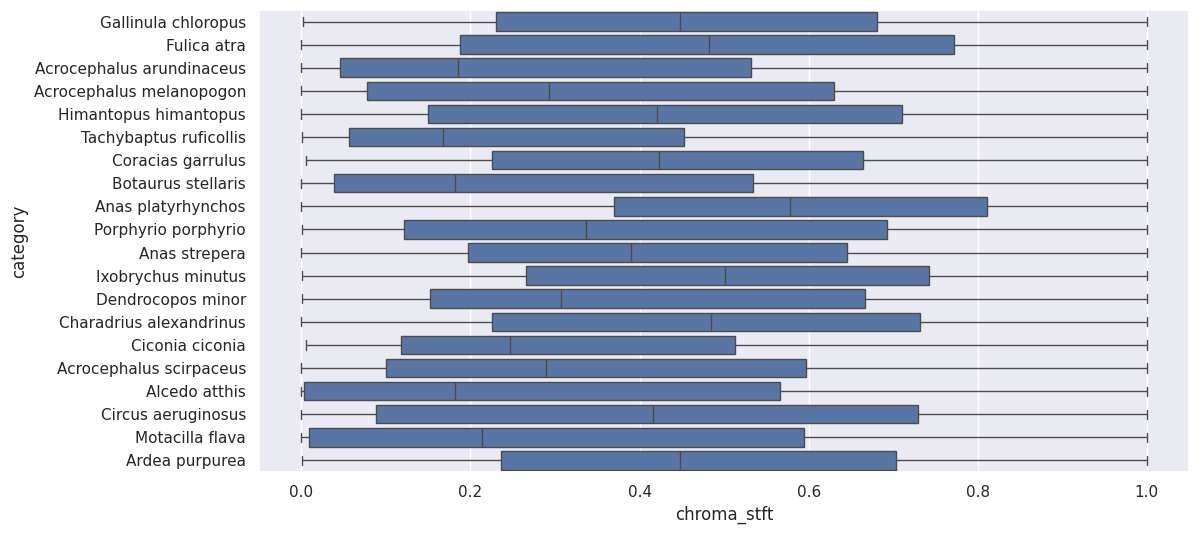

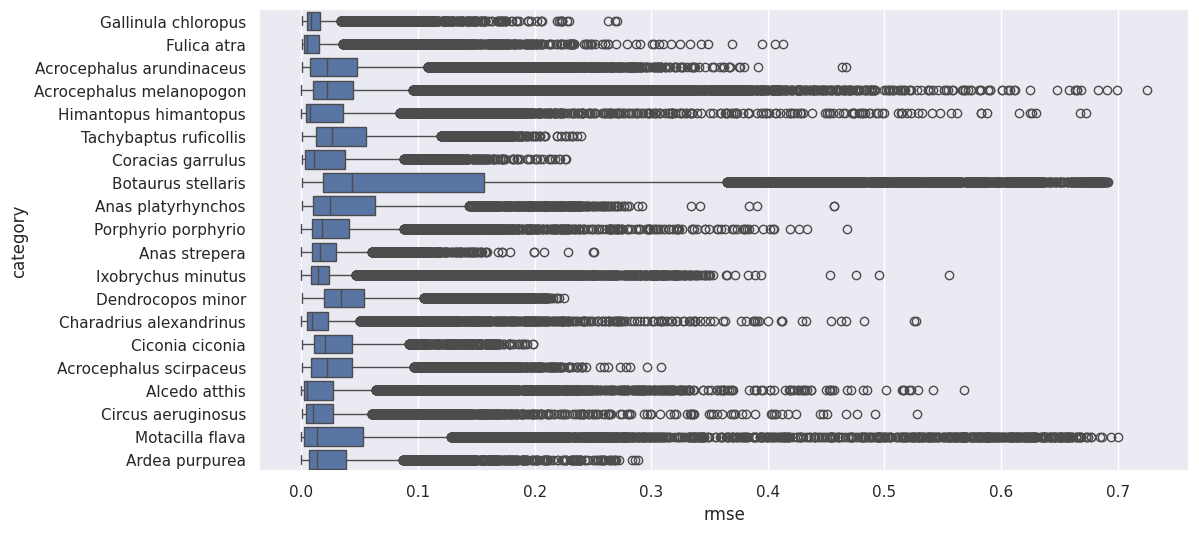

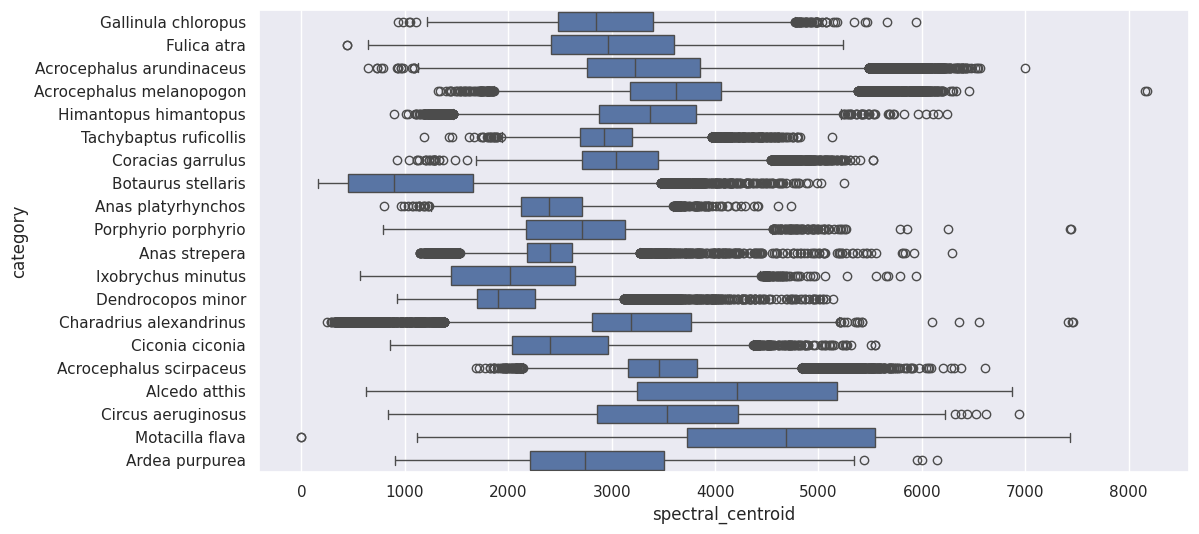

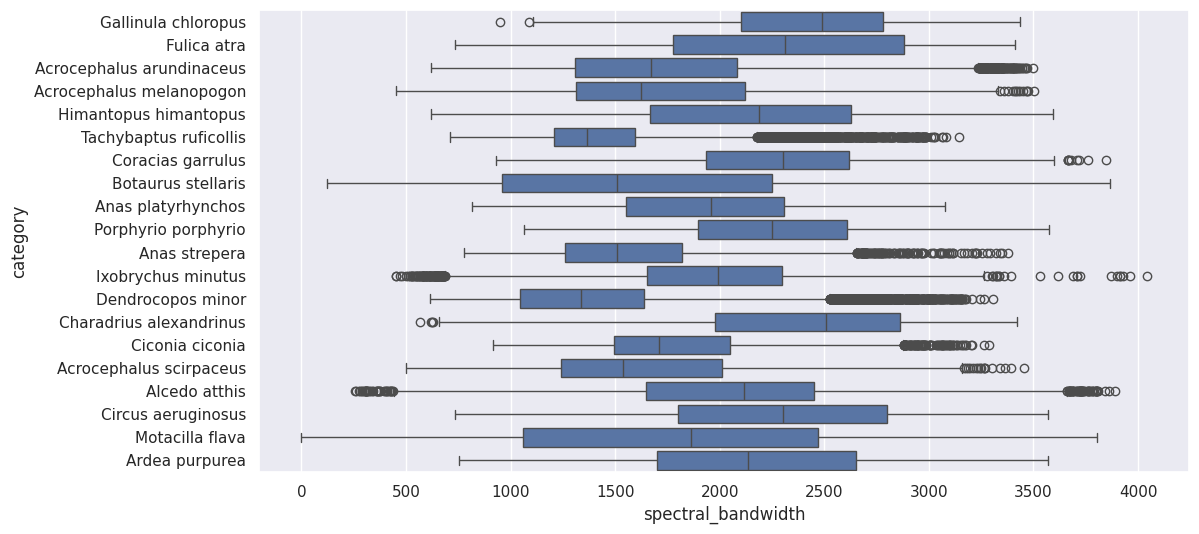

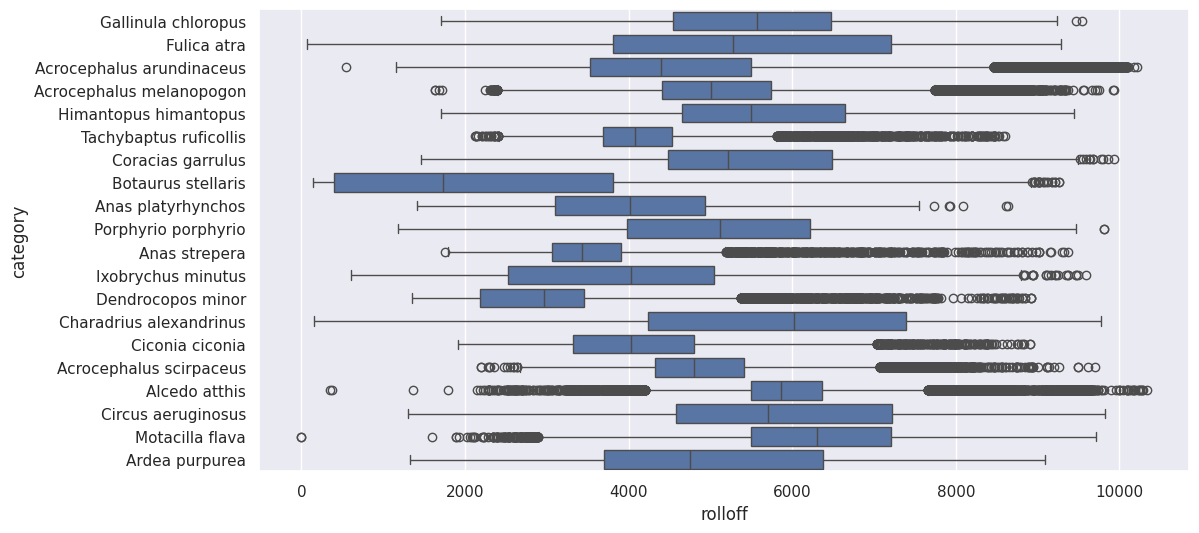

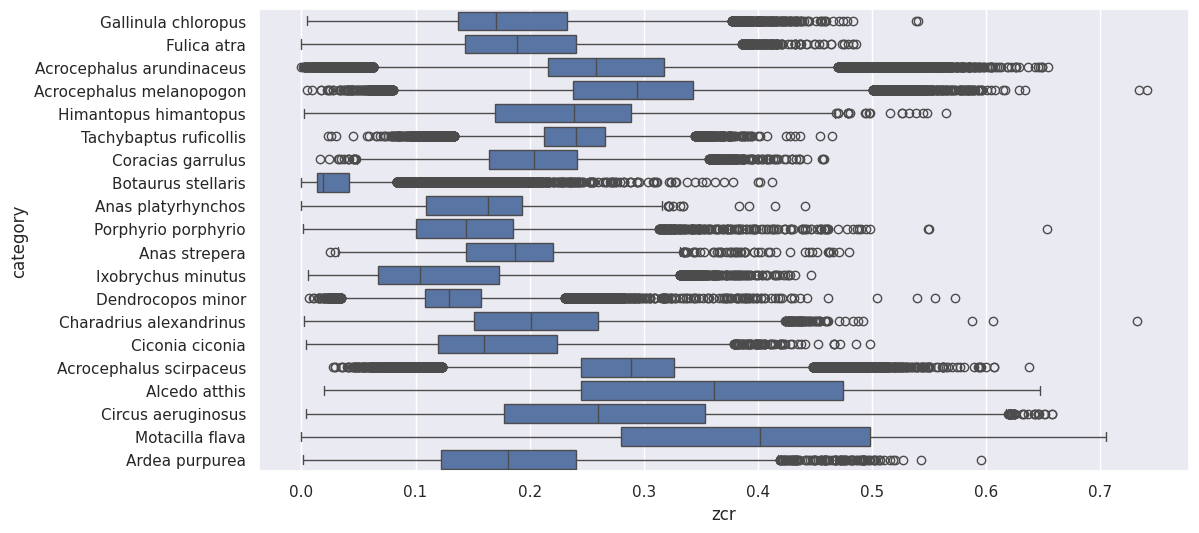

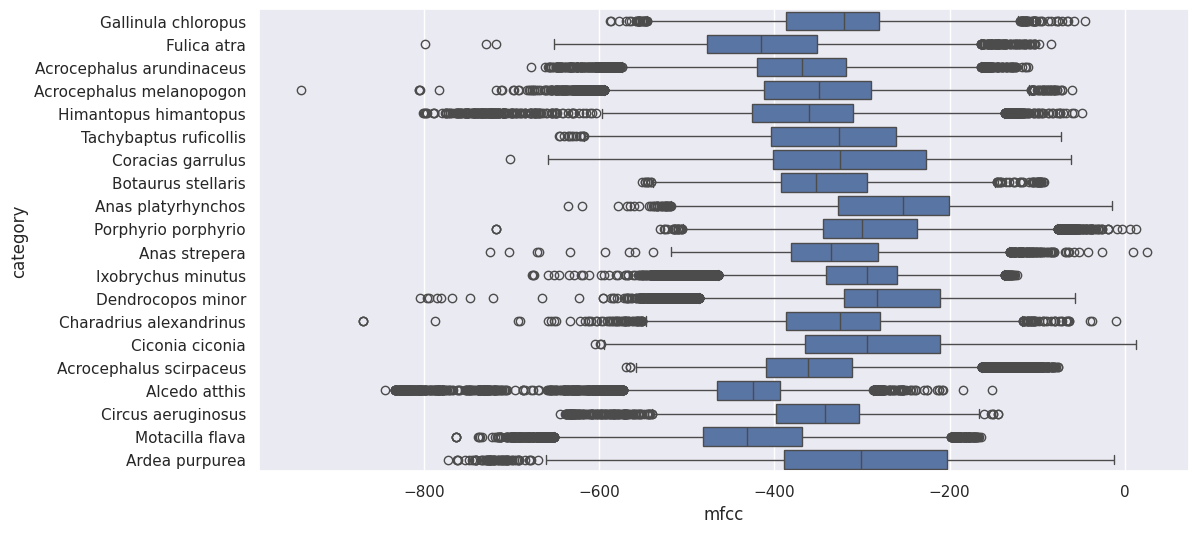

In [14]:
predictors = [ 'chroma_stft', 'rmse','spectral_centroid',
              'spectral_bandwidth','rolloff', 'zcr', 'mfcc']
for predictor in predictors:
    sns.boxplot(data=exploded_audios_df,x=predictor, y="category")
    plt.show()

In [15]:
def remove_outliers(df, columns, n_std):

    for col in columns:
        print('Dropping outliers on column: {}'.format(col))

        mean = df[col].mean()
        sd = df[col].std()

        df = df[(df[col] <= mean + (n_std * sd))]

    return df
def group_df_by_index(df):
    grouped = df.groupby(df.index)
    result = grouped.agg(lambda x: x.value_counts().index[0])
    return result

In [16]:
TRAIN = exploded_audios_df[exploded_audios_df['label'] == 'TRAIN']
TEST = exploded_audios_df[(exploded_audios_df['label'] == 'TEST') | (exploded_audios_df['label'] == 'VAL')]

In [17]:
X = TRAIN[predictors]
y = TRAIN['category']

sampler = RandomUnderSampler(sampling_strategy='majority')
X_resampled, y_resampled = sampler.fit_resample(X, y)

clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-1))
clf.fit(X_resampled, y_resampled)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(tol=0.1))])

In [18]:
test_preds = pd.DataFrame(clf.predict(TEST[predictors]), index=TEST.index)
test_preds.head(5)

,0
0,Charadrius alexandrinus
0,Acrocephalus melanopogon
0,Circus aeruginosus
0,Circus aeruginosus
0,Circus aeruginosus


In [19]:
grouped_test_preds = group_df_by_index(test_preds)
grouped_test_preds.columns = ['category']
GT_grouped_test = group_df_by_index(TEST)
grouped_test_preds.head(5)

,category
0,Circus aeruginosus
11,Acrocephalus melanopogon
12,Circus aeruginosus
40,Circus aeruginosus
41,Acrocephalus melanopogon


In [20]:
TRAIN_NO_OUTLIERS = remove_outliers(TRAIN,predictors,2.5)

Dropping outliers on column: chroma_stft
Dropping outliers on column: rmse
Dropping outliers on column: spectral_centroid
Dropping outliers on column: spectral_bandwidth
Dropping outliers on column: rolloff
Dropping outliers on column: zcr
Dropping outliers on column: mfcc


In [21]:
X = TRAIN_NO_OUTLIERS[predictors]
y = TRAIN_NO_OUTLIERS['category']

GT_grouped_test = group_df_by_index(TEST)

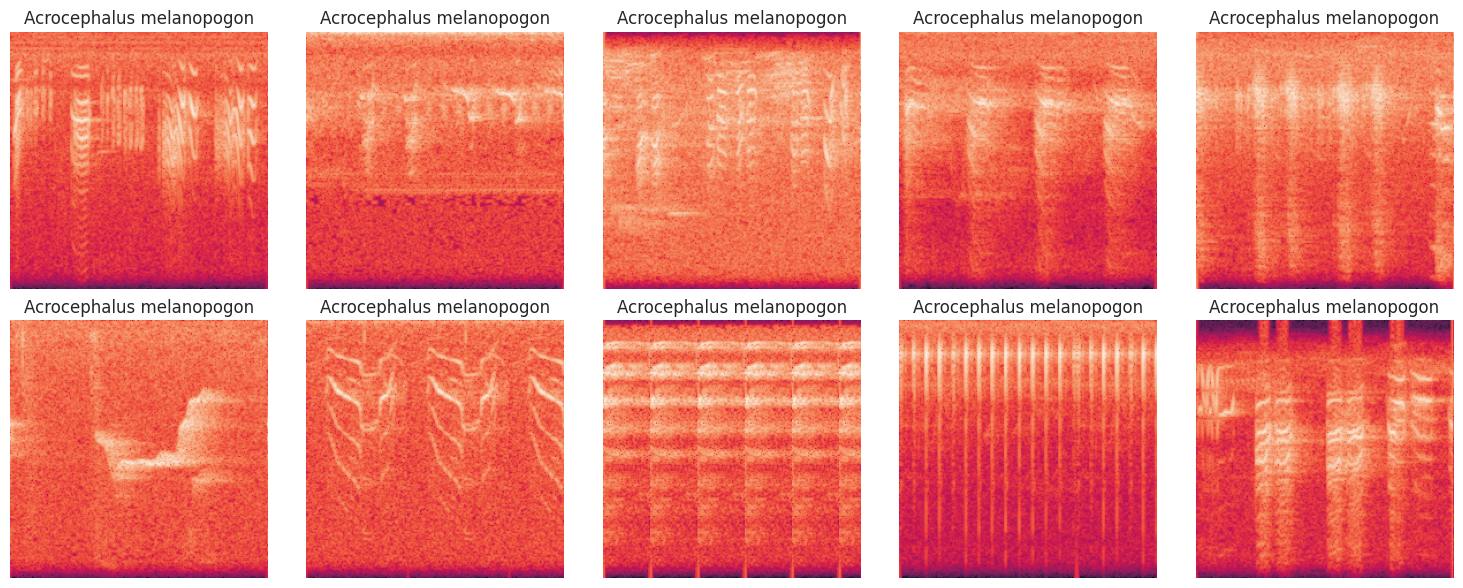

In [22]:
train_val_test_split(spectograms_df, spectograms_df['Category'].unique(), ['TRAIN', 'VAL', 'TEST'], [70, 20, 10])

spectograms_df_tmp = spectograms_df.copy()
spectograms_df_tmp['File'] =  spectograms_df['Category'] + '/' + spectograms_df['File']
df_train = spectograms_df_tmp[spectograms_df_tmp['Set'] == 'TRAIN']
df_val = spectograms_df_tmp[spectograms_df_tmp['Set'] == 'VAL']
random_indices = random.sample(range(spectograms_df_tmp.shape[0]), 10)
images = []
for index in random_indices:
    file = spectograms_df_tmp.iloc[index]['File']
    label = spectograms_df_tmp.iloc[index]['Category']
    image = np.load(SPECTOGRAMS_PATH + '/'+ file)
    images.append(image)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f"{label}")
plt.tight_layout()
plt.show()

#Task: Define a function that creates models without and With specified Optimization techniques


In [56]:

import joblib


def sgd_class():
    X = TRAIN_NO_OUTLIERS[predictors]
    y = TRAIN_NO_OUTLIERS['category']

    kf = KFold(n_splits=5, shuffle=True)
    accuracies = []
    f1_scores = []
    precision_scores = []
    recall_scores = []

    best_f1 = -1
    best_model = None
    last_cf_mat = None

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        sampler = RandomUnderSampler(sampling_strategy='majority')
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

        clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=2000, tol=1e-1))
        clf.fit(X_resampled, y_resampled)

        test_preds = pd.DataFrame(clf.predict(TEST[predictors]), index=TEST.index)
        grouped_test_preds = group_df_by_index(test_preds)
        grouped_test_preds.columns = ['category']

        GT_grouped_test = group_df_by_index(TEST)
        GT_grouped_test = GT_grouped_test.reindex(grouped_test_preds.index)

        y_true = GT_grouped_test['category']
        y_pred = grouped_test_preds['category']

        cf_mat = confusion_matrix(y_true, y_pred)
        last_cf_mat = cf_mat

        f1 = f1_score(y_true, y_pred, average='macro')
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

        accuracies.append(acc)
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

        if f1 > best_f1:
            best_f1 = f1
            best_model = clf

    print(f"Average Accuracy     : {np.mean(accuracies) * 100:.2f}%")
    print(f"Average F1-score     : {np.mean(f1_scores) * 100:.2f}%")
    print(f"Average Precision    : {np.mean(precision_scores) * 100:.2f}%")
    print(f"Average Recall       : {np.mean(recall_scores) * 100:.2f}%")

    sns.heatmap(last_cf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Last Fold)")
    plt.show()

    joblib.dump(best_model, 'best_sgd_model.pkl')

In [36]:


def simple_cnn():
    global spectograms_df
    num_classes = len(spectograms_df['Category'].unique())

    category_to_int = {category: i for i, category in enumerate(spectograms_df['Category'].unique())}
    spectograms_df['label_int'] = spectograms_df['Category'].map(category_to_int)

    spectograms_df['full_path'] = spectograms_df.apply(
        lambda row: os.path.join(SPECTOGRAMS_PATH, row['Category'], row['File']), axis=1
    )
    spectograms_df = spectograms_df[spectograms_df['full_path'].apply(os.path.exists)].copy()

    train_df = spectograms_df[spectograms_df['Set'] == 'TRAIN']
    val_df = spectograms_df[spectograms_df['Set'] == 'VAL']
    test_df = spectograms_df[spectograms_df['Set'] == 'TEST']

    def load_spectrogram_image(path, label):
        def _load_numpy_file(p):
            path_str = p.numpy().decode()
            data = np.load(path_str, allow_pickle=True)
            return data.astype(np.float32)

        img = tf.py_function(func=_load_numpy_file, inp=[path], Tout=tf.float32)
        img.set_shape((224, 224))
        img = tf.expand_dims(img, -1)
        img = tf.repeat(img, 3, axis=-1)
        return img, label

    BATCH_SIZE = 128

    train_dataset = tf.data.Dataset.from_tensor_slices((train_df['full_path'].values, train_df['label_int'].values))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df['full_path'].values, val_df['label_int'].values))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_df['full_path'].values, test_df['label_int'].values))

    train_dataset = train_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    history = model.fit(train_dataset, epochs=8, validation_data=val_dataset)

    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
        plt.legend(['train', 'val'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.show()

    plt.plot(history.history['accuracy'])
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'])
        plt.legend(['train', 'val'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.show()

    model.save("saved_simple_cnn_model.keras")
    y_true = list(test_df['label_int'].values)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")


In [ ]:


import joblib

def random_for_class():
    def classif_model_kfold(X, y, predictors, TEST, group_df_by_index, n_splits=5):
        models = [RandomForestClassifier()]
        results = []

        sampler = RandomUnderSampler(sampling_strategy='majority')
        X_resampled, y_resampled = sampler.fit_resample(X, y)

        kf = KFold(n_splits=n_splits)

        for (i, model) in enumerate(models):
            print("[PROGRESS] Fitting model {} of {}".format(i + 1, len(models)))
            accuracies, f1_scores, precision_scores, recall_scores, cf_mats = [], [], [], [], []

            best_f1 = -1
            best_model = None

            for train_index, val_index in kf.split(X_resampled):
                X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
                y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]

                clf = make_pipeline(StandardScaler(), model)
                clf.fit(X_train, y_train)

                test_preds = pd.DataFrame(clf.predict(TEST[predictors]), index=TEST.index)
                grouped_test_preds = group_df_by_index(test_preds)
                grouped_test_preds.columns = ['category']
                GT_grouped_test = group_df_by_index(TEST)

                y_true = GT_grouped_test['category']
                y_pred = grouped_test_preds['category']

                cf_mat = confusion_matrix(y_true, y_pred)
                accuracy = np.trace(cf_mat) / np.sum(cf_mat)
                f1_sc = f1_score(y_true, y_pred, average='macro')
                precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
                recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

                accuracies.append(accuracy)
                f1_scores.append(f1_sc)
                precision_scores.append(precision)
                recall_scores.append(recall)
                cf_mats.append(cf_mat)

                if f1_sc > best_f1:
                    best_f1 = f1_sc
                    best_model = clf

            results.append({
                'model': model.__class__.__name__,
                'accuracy': np.mean(accuracies),
                'f1_score': np.mean(f1_scores),
                'precision': np.mean(precision_scores),
                'recall': np.mean(recall_scores),
                'confusion_matrix': np.mean(cf_mats, axis=0),
            })

            joblib.dump(best_model, f'best_{model.__class__.__name__.lower()}_model.pkl')
            print(f"[INFO] Best model saved as 'best_{model.__class__.__name__.lower()}_model.pkl'")

        return results

    X = TRAIN_NO_OUTLIERS[predictors]
    y = TRAIN_NO_OUTLIERS['category']
    GT_grouped_test = group_df_by_index(TEST)

    results = classif_model_kfold(X, y, predictors, TEST, group_df_by_index)

    for result in results:
        print("[TEST] Model: ", result['model'])
        print("[TEST] Accuracy: {:.2f} %".format(result['accuracy']*100))
        print("[TEST] F1-score : {:.2f} %".format(result['f1_score']*100))
        print("[TEST] Precision : {:.2f} %".format(result['precision']*100))
        print("[TEST] Recall : {:.2f} %".format(result['recall']*100))
        print("[TEST] Confusion Matrix:\n", result['confusion_matrix'])
        print("\n")

    return results




In [33]:
from tensorflow.keras import regularizers

def SDG():
    global spectograms_df
    num_classes = len(spectograms_df['Category'].unique())

    category_to_int = {category: i for i, category in enumerate(spectograms_df['Category'].unique())}
    spectograms_df['label_int'] = spectograms_df['Category'].map(category_to_int)

    spectograms_df['full_path'] = spectograms_df.apply(
        lambda row: os.path.join(SPECTOGRAMS_PATH, row['Category'], row['File']), axis=1)
    spectograms_df = spectograms_df[spectograms_df['full_path'].apply(os.path.exists)].copy()

    train_df = spectograms_df[spectograms_df['Set'] == 'TRAIN']
    val_df = spectograms_df[spectograms_df['Set'] == 'VAL']
    test_df = spectograms_df[spectograms_df['Set'] == 'TEST']

    def load_spectrogram_image(path, label):
        def _load_numpy_file(p):
            path_str = p.numpy().decode()
            data = np.load(path_str, allow_pickle=True)
            return data.astype(np.float32)

        img = tf.py_function(func=_load_numpy_file, inp=[path], Tout=tf.float32)
        img.set_shape((224, 224))
        img = tf.expand_dims(img, -1)
        img = tf.repeat(img, 3, axis=-1)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return img, label

    BATCH_SIZE = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((train_df['full_path'].values, train_df['label_int'].values))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df['full_path'].values, val_df['label_int'].values))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_df['full_path'].values, test_df['label_int'].values))

    train_dataset = train_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer=regularizers.l2(0.02))
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.03),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(train_dataset, epochs=9, validation_data=val_dataset)

    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='train_acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    model.save("saved_sdg_model.keras")

    y_true, y_pred = [], []
    for X_batch, y_batch in test_dataset:
        preds = model.predict(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print("\n[TEST RESULTS]")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'final_train_accuracy': history.history['accuracy'][-1],
        'final_train_loss': history.history['loss'][-1]
    }

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def AdamW():
    global spectograms_df
    num_classes = len(spectograms_df['Category'].unique())

    category_to_int = {category: i for i, category in enumerate(spectograms_df['Category'].unique())}
    spectograms_df['label_int'] = spectograms_df['Category'].map(category_to_int)

    spectograms_df['full_path'] = spectograms_df.apply(
        lambda row: os.path.join(SPECTOGRAMS_PATH, row['Category'], row['File']), axis=1
    )
    spectograms_df = spectograms_df[spectograms_df['full_path'].apply(os.path.exists)].copy()

    train_df = spectograms_df[spectograms_df['Set'] == 'TRAIN']
    val_df = spectograms_df[spectograms_df['Set'] == 'VAL']
    test_df = spectograms_df[spectograms_df['Set'] == 'TEST']

    def load_spectrogram_image(path, label):
        def _load_numpy_file(p):
            path_str = p.numpy().decode()
            data = np.load(path_str, allow_pickle=True)
            return data.astype(np.float32)

        img = tf.py_function(func=_load_numpy_file, inp=[path], Tout=tf.float32)
        img.set_shape((224, 224))
        img = tf.expand_dims(img, -1)
        img = tf.repeat(img, 3, axis=-1)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return img, label

    BATCH_SIZE = 128
    train_dataset = tf.data.Dataset.from_tensor_slices((train_df['full_path'].values, train_df['label_int'].values))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df['full_path'].values, val_df['label_int'].values))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_df['full_path'].values, test_df['label_int'].values))

    train_dataset = train_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer=regularizers.l1(0.01))
    ])

    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    model.summary()

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(train_dataset,
                        epochs=7,
                        validation_data=val_dataset,
                        callbacks=[early_stop])

    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='train_acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    model.save("saved_adamw_model.keras")

    y_true = []
    y_pred = []

    for batch in test_dataset:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'final_train_accuracy': history.history['accuracy'][-1],
        'final_train_loss': history.history['loss'][-1]
    }


In [41]:
from tensorflow.keras import regularizers

def Adagrad():
    global spectograms_df
    num_classes = len(spectograms_df['Category'].unique())

    category_to_int = {category: i for i, category in enumerate(spectograms_df['Category'].unique())}
    spectograms_df['label_int'] = spectograms_df['Category'].map(category_to_int)

    spectograms_df['full_path'] = spectograms_df.apply(
        lambda row: os.path.join(SPECTOGRAMS_PATH, row['Category'], row['File']), axis=1
    )
    spectograms_df = spectograms_df[spectograms_df['full_path'].apply(os.path.exists)].copy()

    train_df = spectograms_df[spectograms_df['Set'] == 'TRAIN']
    val_df = spectograms_df[spectograms_df['Set'] == 'VAL']
    test_df = spectograms_df[spectograms_df['Set'] == 'TEST']

    def load_spectrogram_image(path, label):
        def _load_numpy_file(p):
            path_str = p.numpy().decode()
            data = np.load(path_str, allow_pickle=True)
            return data.astype(np.float32)

        img = tf.py_function(func=_load_numpy_file, inp=[path], Tout=tf.float32)
        img.set_shape((224, 224))
        img = tf.expand_dims(img, -1)
        img = tf.repeat(img, 3, axis=-1)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        return img, label

    BATCH_SIZE = 64
    train_dataset = tf.data.Dataset.from_tensor_slices((train_df['full_path'].values, train_df['label_int'].values))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_df['full_path'].values, val_df['label_int'].values))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_df['full_path'].values, test_df['label_int'].values))

    train_dataset = train_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(load_spectrogram_image, num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer=regularizers.l1(0.04))
    ])

    model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    model.summary()

    history = model.fit(train_dataset, epochs=6, validation_data=val_dataset)

    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='train_acc')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

    model.save("saved_adagrad_model.keras")

    y_true = []
    y_pred = []

    for batch in test_dataset:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    acc = np.mean(np.array(y_true) == np.array(y_pred))
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'final_train_accuracy': history.history['accuracy'][-1],
        'final_train_loss': history.history['loss'][-1]
    }

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [ ]:
def loss_curve_plot(None):
  epochs = None
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424,532 (9.25 MB)

 Trainable params: 166,548 (650.58 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 760s 8s/step - accuracy: 0.4301 - loss: 3.6360 - val_accuracy: 0.1827 - val_loss: 3.1698
Epoch 2/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 801s 8s/step - accuracy: 0.3224 - loss: 2.8716 - val_accuracy: 0.1984 - val_loss: 3.1259
Epoch 3/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 838s 8s/step - accuracy: 0.1556 - loss: 2.9720 - val_accuracy: 0.1961 - val_loss: 3.1344
Epoch 4/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 777s 8s/step - accuracy: 0.1957 - loss: 3.0014 - val_accuracy: 0.1876 - val_loss: 3.3683
Epoch 5/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 785s 8s/step - accuracy: 0.2017 - loss: 3.1559 - val_accuracy: 0.2082 - val_loss: 2.9748
Epoch 6/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 748s 8s/step - accuracy: 0.1365 - loss: 3.0306 - val_accuracy: 0.2253 - val_loss: 2.9355
Epoch 7/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 875s 9s/step - accuracy: 0.1292 - loss: 2.9671 - val_accuracy: 0.2103 - val_loss: 2.9401


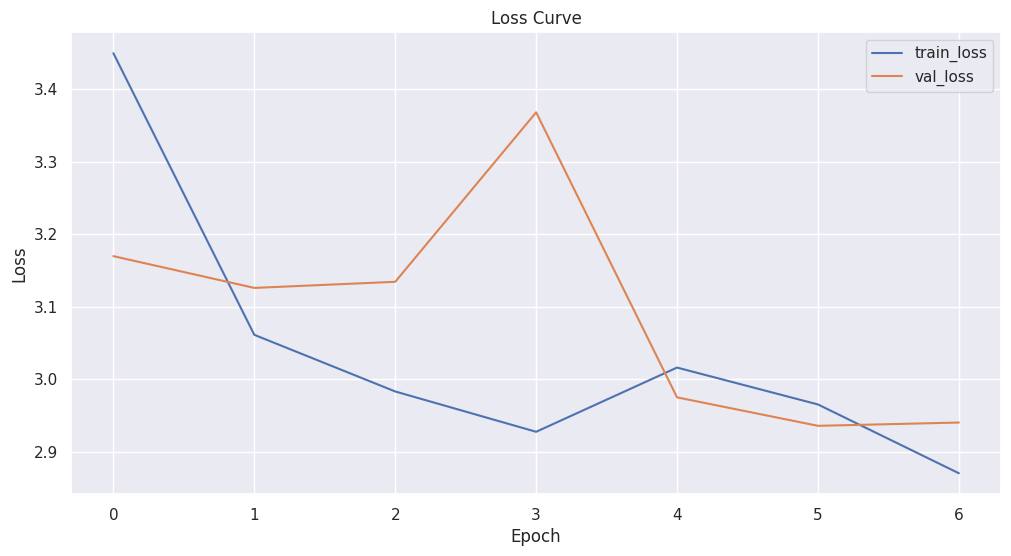

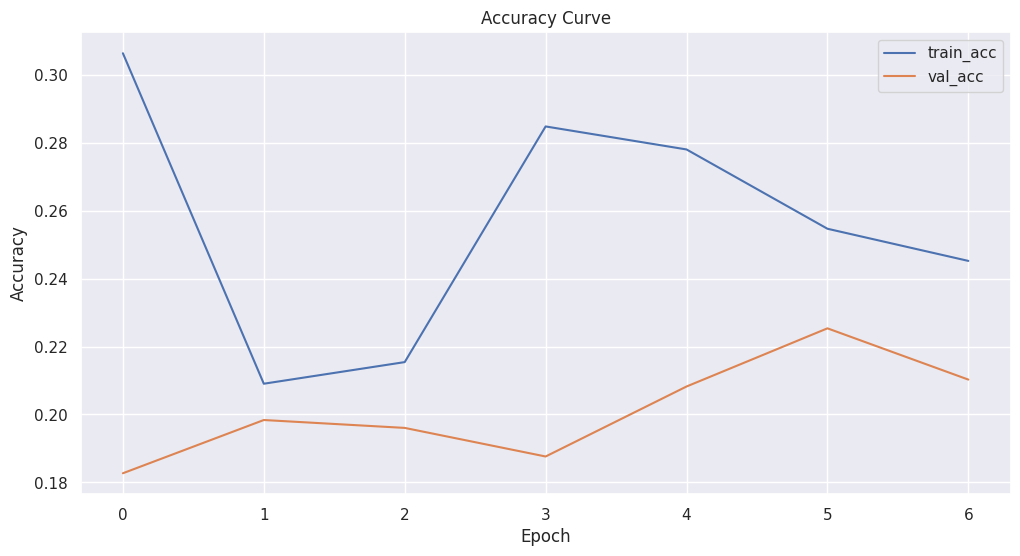

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Accuracy: 0.2203
Precision (macro): 0.0453
Recall (macro): 0.1096
F1-score (macro): 0.0503
Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   7  19   0   0
    0   0]
 [  0   0   0   0   0  19   0   0   0   0   0   0   0   0   1  19   0   0
    0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0  18  22   0   0
    0   0]
 [  0   0   0   0   0   7   0   0   0   0   0   0   6   0  14 232   0   0
    0   0]
 [  0   0   0   0   0   3   0   0   0   0   0  

{'accuracy': np.float64(0.22025912838633688),
 'precision': 0.045317564643343175,
 'recall': 0.10959500466853409,
 'f1_score': 0.05034411518355979,
 'final_train_accuracy': 0.24518759548664093,
 'final_train_loss': 2.8700735569000244}

In [32]:
AdamW()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     5,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,978,420 (22.81 MB)

 Trainable params: 5,978,420 (22.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 548s 6s/step - accuracy: 0.4131 - loss: 44.1590 - val_accuracy: 0.2491 - val_loss: 2.6043
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 591s 6s/step - accuracy: 0.4920 - loss: 1.9051 - val_accuracy: 0.3425 - val_loss: 2.7678
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 619s 6s/step - accuracy: 0.4568 - loss: 2.0137 - val_accuracy: 0.1813 - val_loss: 4.6698
Epoch 4/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 626s 6s/step - accuracy: 0.4272 - loss: 2.3968 - val_accuracy: 0.3637 - val_loss: 2.4013
Epoch 5/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 574s 6s/step - accuracy: 0.3827 - loss: 2.1089 - val_accuracy: 0.3680 - val_loss: 2.6893
Epoch 6/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 621s 6s/step - accuracy: 0.4523 - loss: 2.1935 - val_accuracy: 0.3628 - val_loss: 4.0218
Epoch 7/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - accuracy: 0.5938 - loss: 1.6559 - val_accuracy: 0.4113 - val_loss: 2.8213
Epoch 8/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.5151 - loss: 1.6139 - val_accuracy: 0.4060 - val_loss

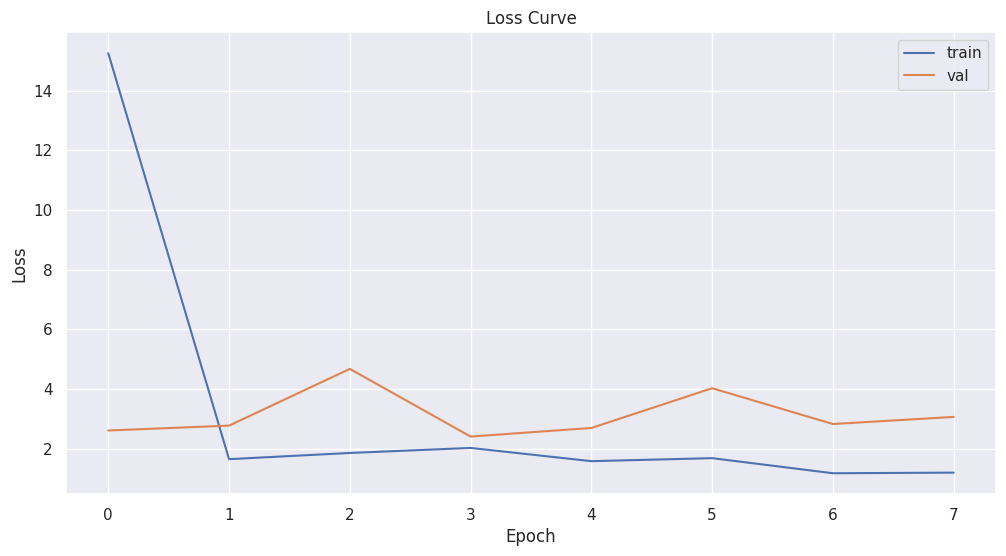

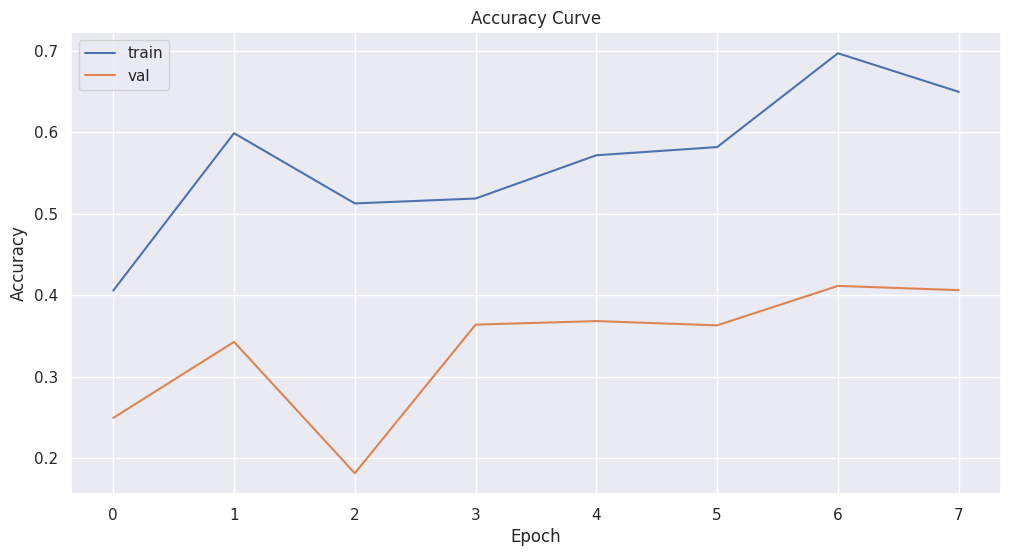

14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step
Accuracy:  0.4046
Precision: 0.4694
Recall:    0.4046
F1-Score:  0.3828


In [37]:
simple_cnn()

In [38]:
random_for_class()

[PROGRESS] Fitting model 1 of 1
[INFO] Best model saved as 'best_randomforestclassifier_model.pkl'
[TEST] Model:  RandomForestClassifier
[TEST] Accuracy: 30.83 %
[TEST] F1-score : 22.60 %
[TEST] Precision : 22.60 %
[TEST] Recall : 27.25 %
[TEST] Confusion Matrix:
 [[0.000e+00 3.032e+02 7.060e+01 2.000e+00 2.000e-01 0.000e+00 2.000e-01
  5.000e+00 5.000e+00 4.000e-01 4.400e+00 1.000e+00 2.200e+00 2.440e+01
  6.000e-01 1.220e+01 1.000e+00 1.060e+01 2.000e-01 3.380e+01]
 [0.000e+00 2.452e+02 1.064e+02 2.000e-01 0.000e+00 0.000e+00 2.000e-01
  0.000e+00 3.600e+00 8.000e-01 1.200e+00 2.200e+00 0.000e+00 3.400e+00
  5.200e+00 6.200e+00 1.800e+00 8.000e-01 2.000e-01 1.600e+00]
 [0.000e+00 8.400e+01 1.736e+02 8.000e-01 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.380e+01 0.000e+00 6.000e-01 4.200e+00 0.000e+00 0.000e+00
  1.000e+00 6.600e+00 0.000e+00 6.000e-01 0.000e+00 3.800e+00]
 [0.000e+00 1.340e+01 7.600e+00 9.420e+01 2.000e-01 0.000e+00 2.000e+00
  0.000e+00 0.000e+00 0.000e+00 4.000e-01 

[{'model': 'RandomForestClassifier',
  'accuracy': np.float64(0.30834697217675944),
  'f1_score': np.float64(0.22595415714329775),
  'precision': np.float64(0.22599307673106175),
  'recall': np.float64(0.27253231063367245),
  'confusion_matrix': array([[0.000e+00, 3.032e+02, 7.060e+01, 2.000e+00, 2.000e-01, 0.000e+00,
          2.000e-01, 5.000e+00, 5.000e+00, 4.000e-01, 4.400e+00, 1.000e+00,
          2.200e+00, 2.440e+01, 6.000e-01, 1.220e+01, 1.000e+00, 1.060e+01,
          2.000e-01, 3.380e+01],
         [0.000e+00, 2.452e+02, 1.064e+02, 2.000e-01, 0.000e+00, 0.000e+00,
          2.000e-01, 0.000e+00, 3.600e+00, 8.000e-01, 1.200e+00, 2.200e+00,
          0.000e+00, 3.400e+00, 5.200e+00, 6.200e+00, 1.800e+00, 8.000e-01,
          2.000e-01, 1.600e+00],
         [0.000e+00, 8.400e+01, 1.736e+02, 8.000e-01, 0.000e+00, 0.000e+00,
          0.000e+00, 0.000e+00, 1.380e+01, 0.000e+00, 6.000e-01, 4.200e+00,
          0.000e+00, 0.000e+00, 1.000e+00, 6.600e+00, 0.000e+00, 6.000e-01,
      

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │        25,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,283,604 (8.71 MB)

 Trainable params: 25,620 (100.08 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/6
192/192 ━━━━━━━━━━━━━━━━━━━━ 741s 4s/step - accuracy: 0.5519 - loss: 7.8681 - val_accuracy: 0.2050 - val_loss: 6.0789
Epoch 2/6
192/192 ━━━━━━━━━━━━━━━━━━━━ 735s 4s/step - accuracy: 0.6126 - loss: 3.2121 - val_accuracy: 0.2019 - val_loss: 5.3963
Epoch 3/6
192/192 ━━━━━━━━━━━━━━━━━━━━ 744s 4s/step - accuracy: 0.6062 - loss: 2.8439 - val_accuracy: 0.2256 - val_loss: 5.0939
Epoch 4/6
192/192 ━━━━━━━━━━━━━━━━━━━━ 746s 4s/step - accuracy: 0.6250 - loss: 2.6695 - val_accuracy: 0.1743 - val_loss: 5.1917
Epoch 5/6
192/192 ━━━━━━━━━━━━━━━━━━━━ 783s 4s/step - accuracy: 0.6050 - loss: 2.5957 - val_accuracy: 0.2181 - val_loss: 4.8678
Epoch 6/6
192/192 ━━━━━━━━━━━━━━━━━━━━ 756s 4s/step - accuracy: 0.6201 - loss: 2.5088 - val_accuracy: 0.1575 - val_loss: 4.9246


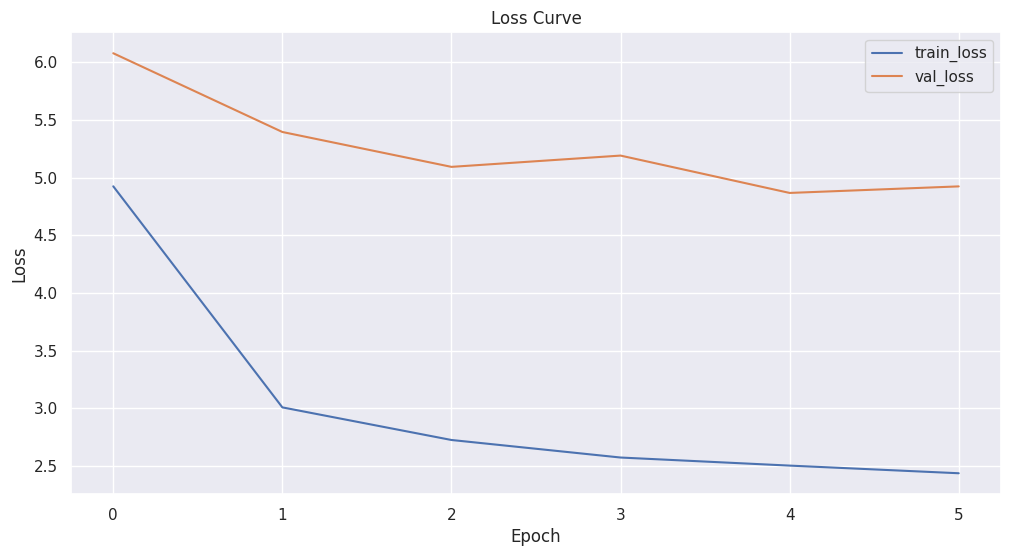

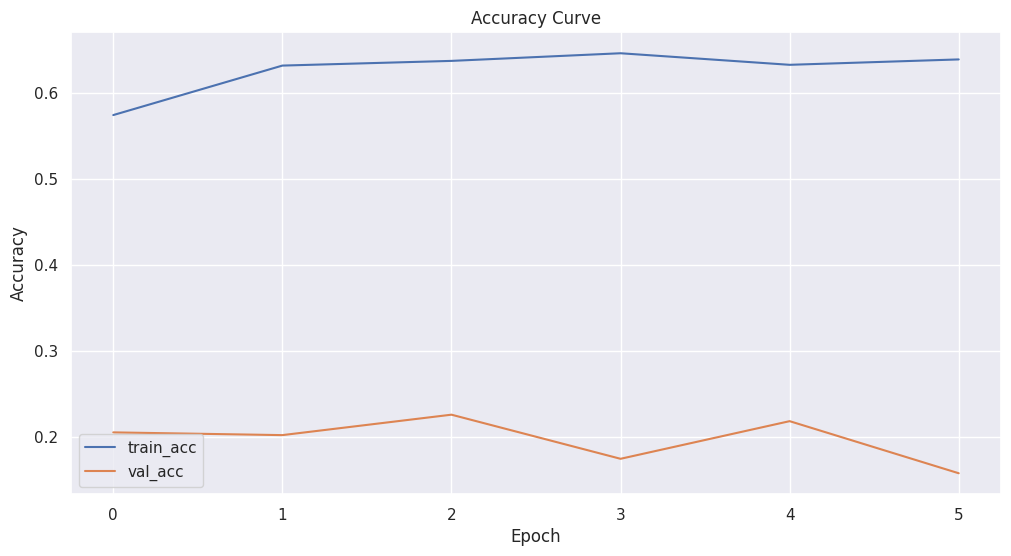

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Accuracy: 0.1472
Precision (

{'accuracy': np.float64(0.14723203769140164),
 'precision': 0.11114921840192485,
 'recall': 0.15670819290643556,
 'f1_score': 0.07016259379674061,
 'final_train_accuracy': 0.6390701532363892,
 'final_train_loss': 2.437544584274292}

In [42]:
Adagrad()

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [53]:


def load_spectrogram_image(path):
    def _load_numpy_file(p):
        path_str = p.numpy().decode()
        data = np.load(path_str, allow_pickle=True)
        return data.astype(np.float32)

    img = tf.py_function(func=_load_numpy_file, inp=[path], Tout=tf.float32)
    img.set_shape((224, 224))
    img = tf.expand_dims(img, -1)
    img = tf.repeat(img, 3, axis=-1)
    return img

def make_predictions(model_path, X, y_true=None):
    model = load_model(model_path)

    if isinstance(X, (np.ndarray, list, pd.Series)):
        if y_true is None:
            y_true = [0] * len(X)

        dataset = tf.data.Dataset.from_tensor_slices((X, y_true))
        dataset = dataset.map(lambda path, label: (load_spectrogram_image(path), label),
                              num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(128).prefetch(tf.data.AUTOTUNE)

    elif isinstance(X, tf.data.Dataset):
        dataset = X
    else:
        raise ValueError("'X' should be either a tf.data.Dataset or a list/array of paths.")

    pred_probs = model.predict(dataset)
    predictions = np.argmax(pred_probs, axis=1)

    if y_true is not None:
        acc = accuracy_score(y_true, predictions)
        prec = precision_score(y_true, predictions, average='weighted', zero_division=0)
        rec = recall_score(y_true, predictions, average='weighted', zero_division=0)
        f1 = f1_score(y_true, predictions, average='weighted', zero_division=0)
        cm = confusion_matrix(y_true, predictions)

        print("\n[Text Confusion Matrix]")
        print(cm)

        print(f"\nAccuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1 Score:  {f1:.4f}")

        return predictions, {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'confusion_matrix': cm
        }

    return predictions


In [54]:

train_val_test_split(spectograms_df, spectograms_df['Category'].unique(), ['TRAIN', 'VAL', 'TEST'], [70, 20, 10])

spectograms_df['full_path'] = spectograms_df.apply(
    lambda row: os.path.join(SPECTOGRAMS_PATH, row['Category'], row['File']), axis=1
)

spectograms_df = spectograms_df[spectograms_df['full_path'].apply(os.path.exists)].copy()

test_df = spectograms_df[spectograms_df['Set'] == 'TEST']

category_to_int = {category: i for i, category in enumerate(spectograms_df['Category'].unique())}
spectograms_df['label_int'] = spectograms_df['Category'].map(category_to_int)
test_df['label_int'] = test_df['Category'].map(category_to_int)

In [55]:
model_path = "saved_simple_cnn_model.keras"
preds, metrics = make_predictions(model_path, test_df['full_path'].values, test_df['label_int'].values)

14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step

[Text Confusion Matrix]
[[  9   0   1   7   0   0   0   0   0   0   0   0   2   0   1   4   0   1
    0   8]
 [  0   9   0   5   0   0   0   0   0   0   0   0   0   2   0  10   0   4
    0   7]
 [  1   0  19   1   0   0   0   6   0   0   2   0   4   0   3   3   0   0
    0   4]
 [  0   0   0 110   0   2   0   0   2   0   0   0   0  10   0  91   0  21
    0  13]
 [  0   0   0  15   4   9   0   0   0   0   0   0   1   1   0 163   4  26
   21   3]
 [  0   0   0   9   0  62   0   0   0   0   0   0   0   2   0  59   0  28
    1   4]
 [  0   0   1  12   0   0   0   0   0   0   0   0   0   4   0  29   0   8
    0  16]
 [  0   0   0   2   0   0   0   0   0   0   0   0   0   1   0   4   0   4
    0  20]
 [  0   1   0   0   0   0   0   0  66   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   1   0   0   0   0   0   6   0   0   0   3   0   3   0   2
    0  22]
 [  0   1   2   0   0   0   0   3   0   6  21   3   2   2   0   2   1   1
    0  14]
 

Congratulations!!
